# Course Completion Prediction

## Problem Framing
**Goal:** Given features derived from an online course platform, predict the likelihood that the given user completed their course in its entirety.

**Business Impact**: Online education platforms lose revenue when a user drops out. By accurately predicting at-risk users early, applied targeted interventions (such as discounts, email nudges, or reminders) can help increase retention and improve user outcomes.

**Technical Framing**: This is a binary classification task with moderately imbalanced classes. The cost of false positives and negatives is asymmetric, so F1 score is used as the primary metric.

# Data Understanding

In [50]:
import pandas as pd

# Load the dataset
file_path = './../data/data.csv'
df = pd.read_csv(file_path)

In [2]:
# Verify there are no missing values present in the dataset
df.isna().sum()

UserID                   0
CourseCategory           0
TimeSpentOnCourse        0
NumberOfVideosWatched    0
NumberOfQuizzesTaken     0
QuizScores               0
CompletionRate           0
DeviceType               0
CourseCompletion         0
dtype: int64

This dataset does not have any missing values.

In [ ]:
# Check whether there are any duplicate rows in the dataset
df.duplicated().value_counts()

False    8123
True      877
Name: count, dtype: int64

In [46]:
df = df.drop_duplicates()

877 duplicate examples were identified and removed.

# Data Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

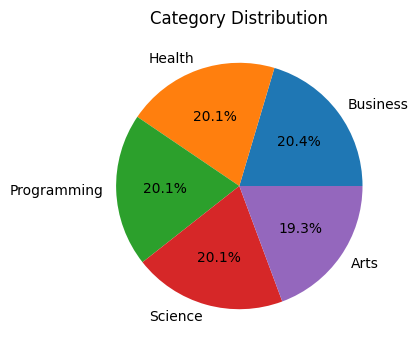

In [ ]:
values = df['CourseCategory'].value_counts()
values.plot(kind = 'pie', figsize = (6,6), autopct='%1.1f%%')
plt.title('Category Distribution')
plt.ylabel('')
plt.show()

Course categories are evenly distributed, so no rebalancing is needed.

count    8123.000000
mean       75.091084
std        14.339876
min        50.005119
25%        62.791226
50%        75.273913
75%        87.497542
max        99.994984
Name: QuizScores, dtype: float64

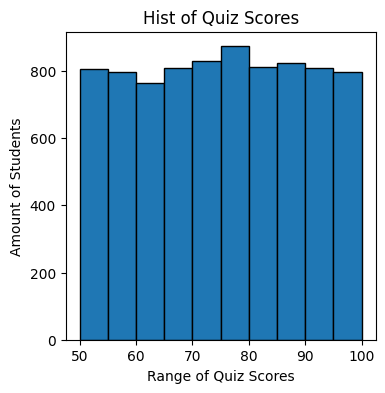

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(df['QuizScores'], bins=10, edgecolor='black')
plt.title('Hist of Quiz Scores')
plt.xlabel('Range of Quiz Scores')
plt.ylabel('Amount of Students')

df['QuizScores'].describe()

The range for quiz scores is almost equally distributed between 50% and 100%, but there seems to be no scores below 50%, and the description confirms it. For some reason zero people got a score below 50%. This is odd, and should be checked upstream. Assuming it's correct, I will continue for demonstration purposes.

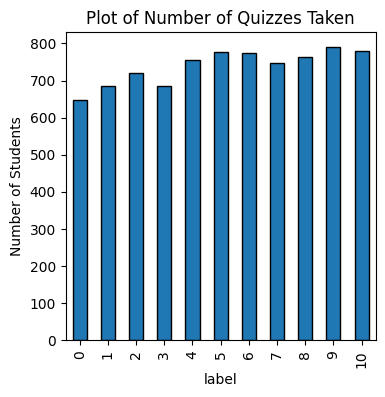

In [ ]:
values = df['NumberOfQuizzesTaken'].value_counts().sort_index()
values.plot(kind = 'bar', edgecolor='black', figsize = (6,6))
plt.title('Plot of Number of Quizzes Taken')
plt.xlabel('label')
plt.ylabel('Number of Students')
plt.show()

In [12]:
# Check correlation between Quiz Scores and Number of Quizzes Taken
corr = df['QuizScores'].corr(df['NumberOfQuizzesTaken'])
print(corr)

-0.0023194963726316455


QuizScores and NumberOfQuizzesTaken aren't correlated, so they should both remain.

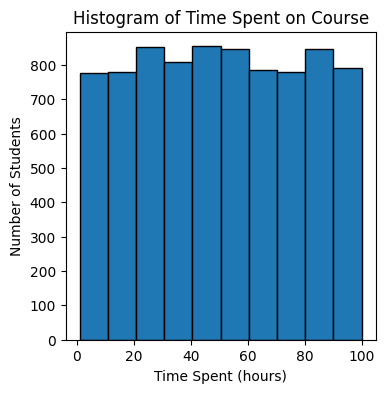

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(df['TimeSpentOnCourse'], bins=10, edgecolor='black')
plt.title('Histogram of Time Spent on Course')
plt.xlabel('Time Spent (hours)')
plt.ylabel('Number of Students')
plt.show()

Bottom half values: 3763
Top half values: 4360


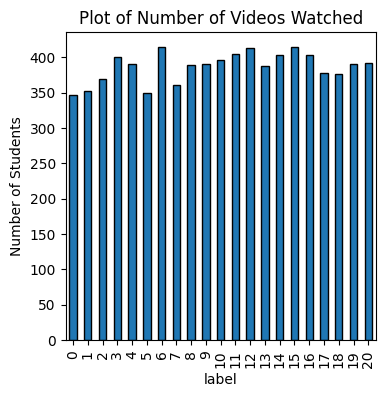

In [ ]:
values = df['NumberOfVideosWatched'].value_counts().sort_index()
values.plot(kind = 'bar', edgecolor='black', figsize = (6,6))
plt.title('Plot of Number of Videos Watched')
plt.xlabel('label')
plt.ylabel('Number of Students')


midpoint = len(values) // 2

bottom_half = values.iloc[:midpoint].sum()
top_half = values.iloc[midpoint:].sum()

print("Bottom half values:", bottom_half)
print("Top half values:", top_half)

There is a right-skew in the number of the videos watched, suggesting more students engage deeply than drop off early.

Number of completions: 3568
Number of non-completions: 4555


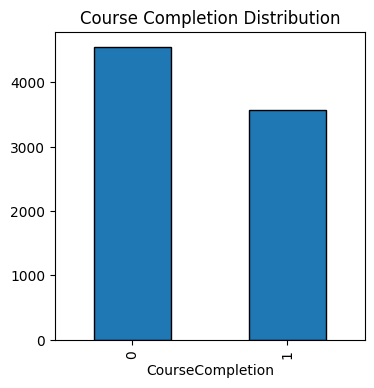

In [ ]:
values = df['CourseCompletion'].value_counts().sort_index()
values.plot(kind = 'bar', edgecolor='black', figsize = (6,6))
plt.title('Course Completion Distribution')

valueCounts = df['CourseCompletion'].value_counts()

print("Number of completions:", valueCounts[1])
print("Number of non-completions:", valueCounts[0])

The class distribution is roughly 56% non-completions and 44% completions. This imbalance towards non-completion is moderately imbalanced, and might affect the predictions of the models, and the class weights were adjusted to compensate.

# Data Prep

In [95]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Load the dataset again to ensure no changes were made
df = pd.read_csv(file_path)
df = df.drop_duplicates()

# Define features
features = ['CourseCategory', 'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores'] # no CompletionRate, lowers F1 score

X = df[features]
y = df['CourseCompletion']

# Identify categorical and numeric columns
categorical_cols = ['CourseCategory']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Define preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
], remainder='passthrough')

# Final evaluation holdout set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Set up stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

`CompletionRate` was excluded due to data leakage concerns since it directly reflects progress.

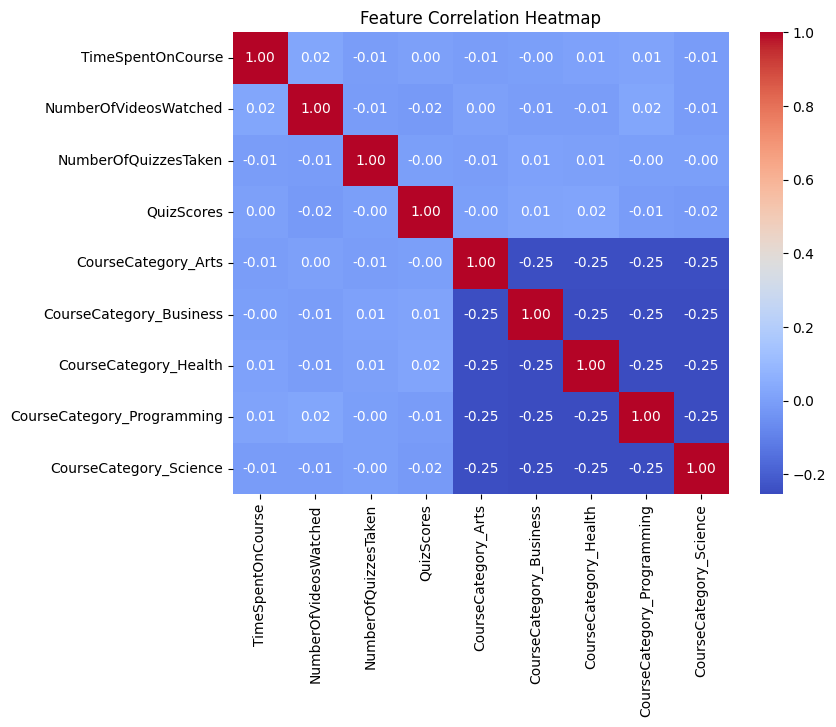

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# For numeric features (after encoding categorical ones)
df_encoded = pd.get_dummies(df[features], columns=['CourseCategory'])

corr_matrix = df_encoded.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


The existing features are useful, though out of the tested synthetic features, almost all overlap significantly with other features.

When using synthetic features such as `TimePerVideo` or `ScorePerQuiz`, they brought the accuracy and f1 scores down, so they were left out of the final models.

# Models

#### Model Running Function

In [96]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.model_selection import GridSearchCV

def run_grid_search(estimator, param_grid, X, y, skf, scoring='f1'):
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=skf,
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )

    grid.fit(X, y)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_

    return best_params, best_score, best_model

def generate_classification_plots(model_name, y_true, y_probs, y_pred, return_figs=False):
    import matplotlib.pyplot as plt
    import seaborn as sns

    figs = {}

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    fig1, ax1 = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'{model_name} - Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_xticklabels(['Incompleted', 'Completed'])
    ax1.set_yticklabels(['Incompleted', 'Completed'])
    if return_figs: figs['confusion_matrix'] = fig1
    else: plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    ax2.plot(["0", 1], [0, 1], linestyle='--', color='gray')
    ax2.set_title(f"ROC Curve - {model_name}")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.legend()
    ax2.grid(True)
    if return_figs: figs['roc_curve'] = fig2
    else: plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)

    fig3, ax3 = plt.subplots(figsize=(6, 4))
    ax3.plot(recall, precision, label=f"Avg Precision = {avg_precision:.4f}")
    ax3.set_title(f"Precision-Recall Curve - {model_name}")
    ax3.set_xlabel("Recall")
    ax3.set_ylabel("Precision")
    ax3.legend()
    ax3.grid(True)
    if return_figs: figs['pr_curve'] = fig3
    else: plt.show()

    print(f"\nClassification Report - {model_name}\n")
    print(classification_report(y_true, y_pred))

    return figs if return_figs else None

### Baseline

In [97]:
from sklearn.dummy import DummyClassifier

# Create dummy model with stratified strategy
dummy_stratified = DummyClassifier(strategy="stratified", random_state=42)
dummy_stratified.fit(X_train, y_train)

# Predict on test set
y_pred_dummy = dummy_stratified.predict(X_test)

# Evaluate
dummy_acc = accuracy_score(y_test, y_pred_dummy)
dummy_f1 = f1_score(y_test, y_pred_dummy)
dummy_auc = roc_auc_score(y_test, y_pred_dummy)

print(f"Stratified Dummy F1 Score: {dummy_f1:.4f}")
print(f"Stratified Dummy Accuracy: {dummy_acc:.4f}")
print(f"Stratified Dummy AUC: {dummy_auc:.4f}")


Stratified Dummy F1 Score: 0.4548
Stratified Dummy Accuracy: 0.5175
Stratified Dummy AUC: 0.5111


### Decision Tree

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Decision Tree - {'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_leaf_nodes': 50, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
F1: 0.7548
Acc: 0.7458
AUC: 0.8567


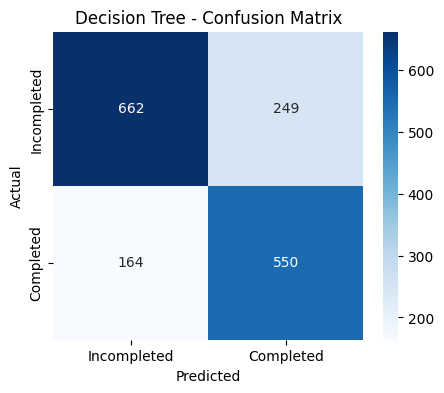

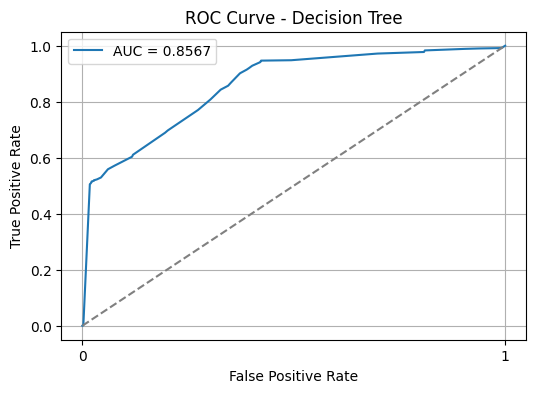

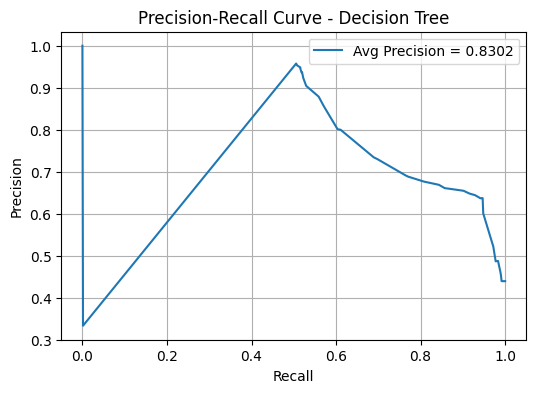


Classification Report - Decision Tree

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       911
           1       0.69      0.77      0.73       714

    accuracy                           0.75      1625
   macro avg       0.74      0.75      0.74      1625
weighted avg       0.75      0.75      0.75      1625



In [99]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'model__max_depth': [None, 5, 10, 20],
    'model__max_leaf_nodes': [None, 20, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 5, 10],
    'model__criterion': ['gini', 'entropy']
}

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

tree_best_params, tree_best_f1, tree_model = run_grid_search(
    pipeline,
    param_grid,
    X_train,
    y_train,
    skf,
    scoring='f1'
)

tree_model.fit(X_train, y_train)
val_preds = tree_model.predict(X_test)
val_probs = tree_model.predict_proba(X_test)[:, 1]
tree_acc = accuracy_score(y_test, val_preds)
tree_auc = roc_auc_score(y_test, val_probs)

print(f"Best Decision Tree - {tree_best_params}")
print(f"F1: {tree_best_f1:.4f}\nAcc: {tree_acc:.4f}\nAUC: {tree_auc:.4f}")
generate_classification_plots("Decision Tree", y_test, val_probs, val_preds)

##### Model Performance:
The decision tree shows reasonable discriminatory ability between classes, with an AUC above .84. However, class-level performance is slightly imbalanced. The PR curve shows rising precision up until 50% recall, where it begins to decline to ~0.6 until 90% recall. Its sharp rise suggests poor calibration at low recall, likely due to the model's lack of generalization.

##### Confusion Matrix:
The model shows slightly better performance at predicting non-completion than completion. This may reflect the slight class imbalance that the label holds.

##### Classification Report
Recall for completions is lower than for non-completions, suggesting that some users who did complete the course are being missed.

### Random Forest

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest - {'model__criterion': 'gini', 'model__max_depth': None, 'model__max_leaf_nodes': 20, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
F1: 0.7460
Acc: 0.7495
AUC: 0.8618


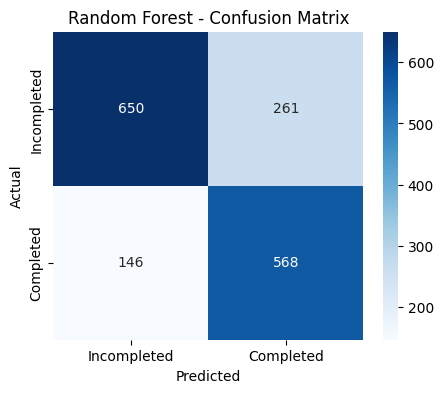

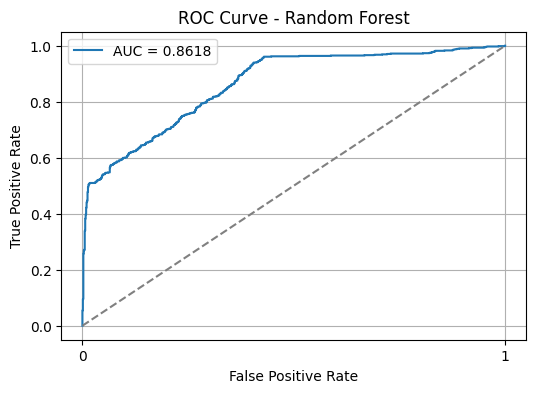

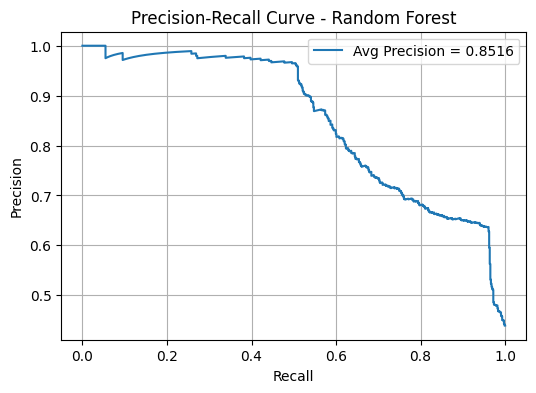


Classification Report - Random Forest

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       911
           1       0.69      0.80      0.74       714

    accuracy                           0.75      1625
   macro avg       0.75      0.75      0.75      1625
weighted avg       0.76      0.75      0.75      1625



In [100]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'model__max_depth': [None, 5, 10, 20],
    'model__max_leaf_nodes': [None, 20, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 5, 10],
    'model__criterion': ['gini', 'entropy']
}

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

forest_best_params, forest_best_f1, forest_model = run_grid_search(
    pipeline,
    param_grid,
    X_train,
    y_train,
    skf,
    scoring='f1'
)

forest_model.fit(X_train, y_train)
val_preds = forest_model.predict(X_test)
val_probs = forest_model.predict_proba(X_test)[:, 1]
forest_acc = accuracy_score(y_test, val_preds)
forest_auc = roc_auc_score(y_test, val_probs)

print(f"Best Random Forest - {forest_best_params}")
print(f"F1: {forest_best_f1:.4f}\nAcc: {forest_acc:.4f}\nAUC: {forest_auc:.4f}")
generate_classification_plots("Random Forest", y_test, val_probs, val_preds)

##### Model Performance:
The random forest separates the classes better compared to the decision tree. This makes sense, the ensemble averaging from multiple trees helped reduce variance. The PR curve shows good performance, with nearly 1.0 precision up until around 50% recall where it curves down to 0.6 to ~90% recall and then dropping down to ~0.4. This tells us that it will almost always identify around 50% of dropouts, and likely identify the remaining ones.

##### Confusion Matrix:
Compared to the decision tree, the random forest has lower recall for completions, meaning more users who actually finished the course were wrongly predicted to not complete the course. However, it does reduce false positives, so it's being more cautious about predicting completion - at the cost of missing actual completions.

##### Classification Report
Precision is balanced across both classes, but recall is noticeably lower for completions. That means the model is less effective at catching users who actually finished the course, even if it's equally accurate when it does predict completion.

### LightGBM

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best LightGBM - {'model__max_depth': -1, 'model__min_child_samples': 5, 'model__min_split_gain': 0.1, 'model__num_leaves': 31}
F1: 0.7533
Acc: 0.7526
AUC: 0.8624


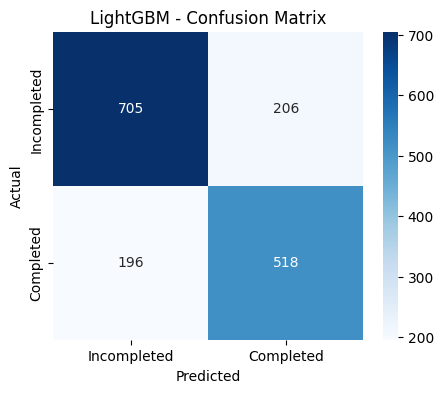

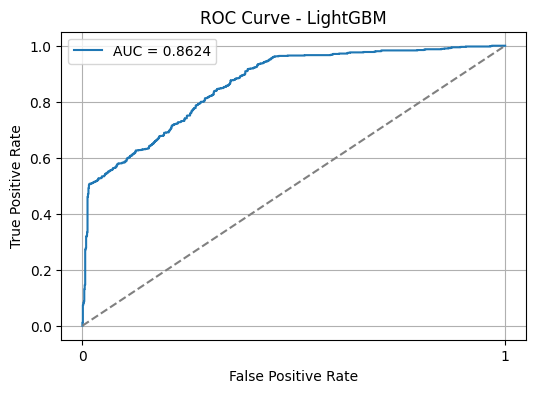

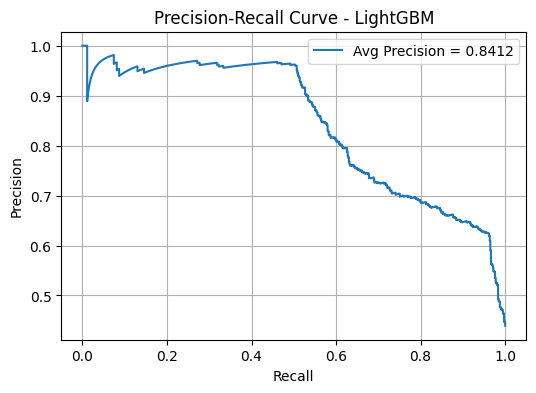


Classification Report - LightGBM

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       911
           1       0.72      0.73      0.72       714

    accuracy                           0.75      1625
   macro avg       0.75      0.75      0.75      1625
weighted avg       0.75      0.75      0.75      1625



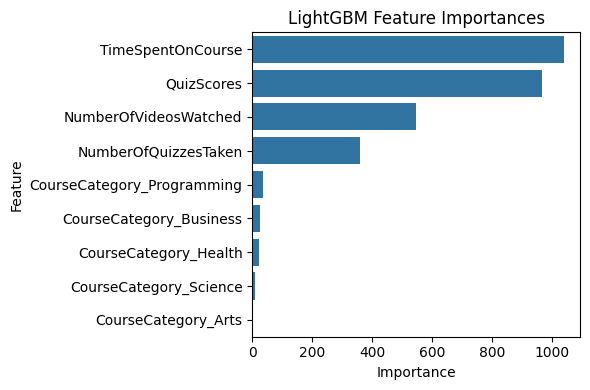

In [101]:
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore", message=".*valid feature names.*")

param_grid = {
    'model__num_leaves': [20, 31, 50, 100],
    'model__max_depth': [-1, 5, 10, 20],
    'model__min_child_samples': [5, 10, 20],  
    'model__min_split_gain': [0.0, 0.1, 0.3],
}

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', lgb.LGBMClassifier(verbosity=-1, random_state=42, class_weight='balanced'))
])

light_best_params, light_best_f1, light_model = run_grid_search(
    pipeline,
    param_grid,
    X_train,
    y_train,
    skf,
    scoring='f1'
)

light_model.fit(X_train, y_train)
val_preds = light_model.predict(X_test)
val_probs = light_model.predict_proba(X_test)[:, 1]
light_acc = accuracy_score(y_test, val_preds)
light_auc = roc_auc_score(y_test, val_probs)

print(f"Best LightGBM - {light_best_params}")
print(f"F1: {light_best_f1:.4f}\nAcc: {light_acc:.4f}\nAUC: {light_auc:.4f}")
generate_classification_plots("LightGBM", y_test, val_probs, val_preds)

# Feature Importance Plot for LightGBM
importances = light_model.named_steps['model'].feature_importances_
# Get feature names after preprocessing
cat_features = light_model.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(['CourseCategory'])
feature_names = list(cat_features) + [col for col in X_train.columns if col not in ['CourseCategory']]
import pandas as pd
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

##### Model Performance:
It has the highest F1 score of the 3 models at 74.09%, along with the highest accuracy at 76.12%. The PR curve shows strong performance, with high average precision up until about 50% recall. After that point, precision gradually declines, but remains above 0.6 until about 80% recall, which is still acceptable.

##### Confusion Matrix:
The model leans toward predicting non-completion. This likely is due to the class-imbalance of `CourseCompletion`.

##### Classification Report
The model has strong and relatively balanced precision for both classes. However, recall is higher for non-completions than completions, which means it's better at identifying students who did not complete their course than those who did.

##### Feature Importance
The LightGBM model relies heavily on just four features: `TimeSpentOnCourse`, `QuizScores`, `NumberOfVideosWatched`, and `NumberOfQuizzesTaken`. Of these, `TimeSpentOnCourse` and `QuizScores` contribute the most. The encoded course category features have nearly zero impact, suggesting that the course material has minimal influence on whether the student completes it.

# Analysis

In [103]:
model_f1 = {
    'Decision Tree': tree_best_f1,
    'Random Forest': forest_best_f1,
    'LightGBM': light_best_f1
}

# Find model with the best f1 score
best_model_f1 = max(model_f1, key=model_f1.get)
best_f1_score = model_f1[best_model_f1]

model_acc = {
    'Decision Tree': tree_acc,
    'Random Forest': forest_acc,
    'LightGBM': light_acc
}

# Find model with the best accuracy
best_model_acc = max(model_acc, key=model_acc.get)
best_acc_score = model_acc[best_model_acc]

print(f"Model with the best F1 Score: {best_model_f1} with {best_f1_score*100:.2f}%")
print(f"Model with the best Accuracy: {best_model_acc} with {best_acc_score*100:.2f}%")

Model with the best F1 Score: Decision Tree with 75.48%
Model with the best Accuracy: LightGBM with 75.26%


In [102]:
model_comparison_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'LightGBM', 'Dummy'],
    'F1 Score': [tree_best_f1, forest_best_f1, light_best_f1, dummy_f1],
    'Accuracy': [tree_acc, forest_acc, light_acc, dummy_acc],
    'AUC': [tree_auc, forest_auc, light_auc, dummy_auc]
})

model_comparison_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

,Model,F1 Score,Accuracy,AUC
0,Decision Tree,0.754784,0.745846,0.856697
1,LightGBM,0.753320,0.752615,0.862439
2,Random Forest,0.745974,0.749538,0.861823
3,Dummy,0.454798,0.517538,0.511099


### Discussion

#### Evaluation Metric

I chose to use F1 as the main evaluation metric as the model is intended to identify students at risk of not completing the course, in order to enable early intervention. False positives and false negatives both are costly (such as giving discounted prices to predicted drop-outs), and F1 helps ensure balanced performance.

#### Overfitting

To mitigate overfitting, I used stratified K-Fold cross-validation when tuning all models, along with using a train_test_split to verify my findings. I also monitored whether performance dropped when including all features or synthetic features, removing those that reduced generalization. These steps helped reduce the risk of overfitting.

### Summary

To predict course completion outcomes, I evaluated three classifiers: Decision Tree, Random Forest, and LightGBM, using 5-fold stratified cross-validation and F1 score as the primary evaluation metric.
- **Decision Tree** reached the highest F1 score at 75.48%, beating LightGBM by ~0.14%. Even though this is a minor advantage, it is a single tree and is less likely to generalize well.
- **LightGBM** reached the second highest F1 score at 75.33%, following the decision tree. As an ensemble, this model is more likely to accurately generalize to new data than the decision tree.
- **Random Forest** After LightGBM, the random forest model had a F1 score of 74.60%, about 0.73% below LightGBM.
- **Dummy Classifier** performed the worst, as expected.

Feature engineering included experiments with multiple synthetic features. They did not improve model performance due to high feature correlation, and therefore were excluded from the final model.

This model could be deployed in an online course platform to identify users at risk of not completing their course. Interventions such as reminder emails, tailored support, or adaptive pacing could be triggered automatically.

Although the decision tree achieved the highest F1 score, I selected LightGBM as the final model due to its superior AUC, higher accuracy, and better generlaization characteristics as an ensemble method.

# Pipeline & Export

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import lightgbm as lgb

# Define categorical and numeric columns
categorical_cols = ['CourseCategory']
numeric_cols = [col for col in features if col not in categorical_cols]

# Preprocessing: encode categorical
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
], remainder='passthrough')  # Leave numeric columns untouched

# Pipeline: preprocessing + model
lightgbm_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', lgb.LGBMClassifier(**light_best_params, class_weight='balanced', random_state=42))
])

# Fit on full training fold
lightgbm_pipeline.fit(X, y)

# Save pipeline
import joblib
joblib.dump(lightgbm_pipeline, '../model/lightgbm_pipeline.pkl')

['../model/lightgbm_pipeline.pkl']

Input Example

In [78]:
import joblib

pipeline = joblib.load('../model/lightgbm_pipeline.pkl')

def predict_completion(user_input_dict, pipeline_path='../model/lightgbm_pipeline.pkl'):
    required_keys = ['CourseCategory', 'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores']
    for key in required_keys:
        if key not in user_input_dict:
            raise ValueError(f"Missing input: {key}")
        
    df = pd.DataFrame([user_input_dict])
    pipe = joblib.load(pipeline_path)
    pred = pipe.predict(df)[0]
    prob = pipe.predict_proba(df)[0][1]
    return pred, prob

sample_input = {
    'CourseCategory': 'Science',
    'TimeSpentOnCourse': 35.0,
    'NumberOfVideosWatched': 12,
    'NumberOfQuizzesTaken': 5,
    'QuizScores': 78.0
}

print(predict_completion(sample_input))

(np.int64(1), np.float64(0.9517504257488201))
